# 1M recipes evaluation

In [1]:
%pylab ipympl

import numpy as np
import json

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords as nltk_stopwords

from pprint import pprint

from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec, KeyedVectors

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

from json_buffered_reader import JSON_buffered_reader as JSON_br

import pandas as pd

import settings

Populating the interactive namespace from numpy and matplotlib


In [2]:
from ipypb import track

In [3]:
from IPython.display import HTML, Markdown

* load model

In [4]:
wv = KeyedVectors.load("data/wordvectors.kv")

In [5]:
porter = PorterStemmer()
def word_similarity(word_a:str, word_b:str, model=wv, stemmer=porter):
    return model.similarity(stemmer.stem(word_a), stemmer.stem(word_b))

def word_exists(word:str, model=wv, stemmer=porter):
    return stemmer.stem(word) in model


* check for a list of cooking verbs and ingredients whether they're represented by our model

In [6]:
from cooking_vocab import cooking_verbs
from cooking_ingredients import ingredients

model_actions = []
model_ingredients = []

for action in cooking_verbs:
    if word_exists(action):
        model_actions.append(action)

for ingredient in ingredients:
    if word_exists(ingredient):
        model_ingredients.append(ingredient)

In [7]:
pprint(f"found {len(model_actions)} of {len(cooking_verbs)} valid actions and {len(model_ingredients)} of {len(ingredients)} valid ingredients")

'found 109 of 111 valid actions and 160 of 648 valid ingredients'


In [8]:
stemmed_ingredients = [porter.stem(ing) for ing in model_ingredients]
stemmed_actions = [porter.stem(act) for act in model_actions]

## TSNE Plots:

In [9]:
def tsne_plot(tokens, model=wv):
    vecs = []
    labels = []
    for token in tokens:
        vecs.append(model[token])
        labels.append(token)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    plot_values = tsne_model.fit_transform(vecs)
    
    x = []
    y = []
    for value in plot_values:
        x.append(value[0])
        y.append(value[1])
    
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

### 2D projection of Ingredient Space

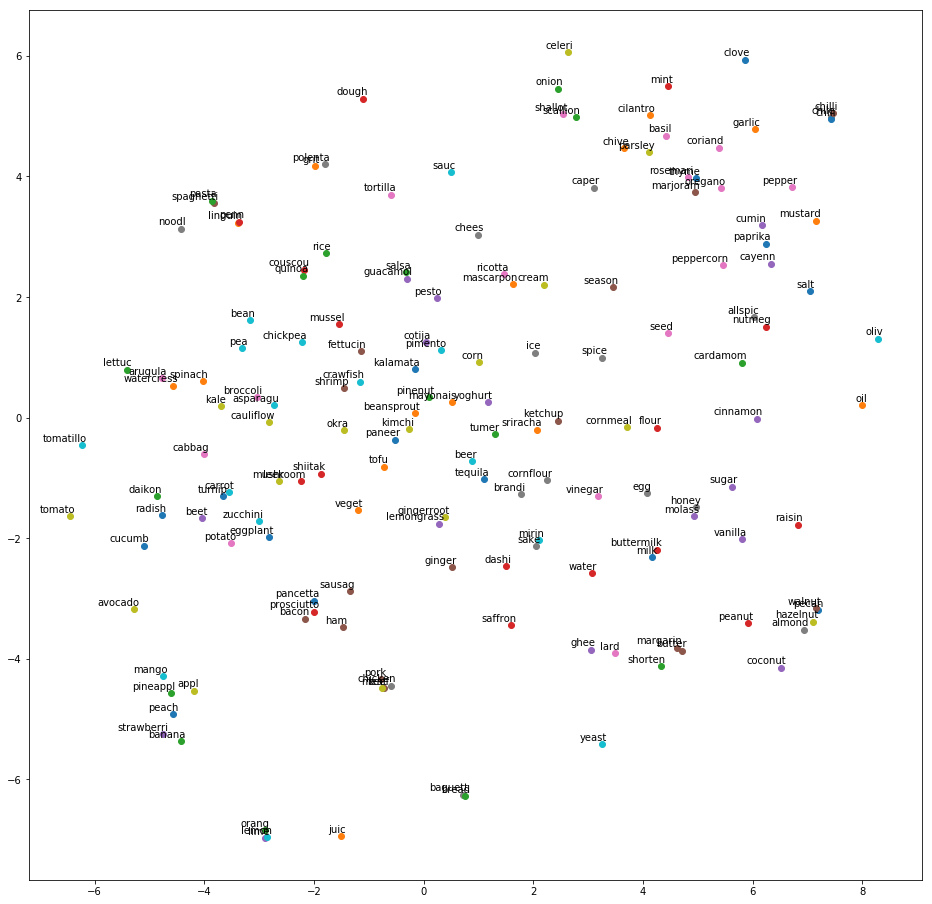

In [10]:
tsne_plot(stemmed_ingredients)

### 2D Projection of Action Space

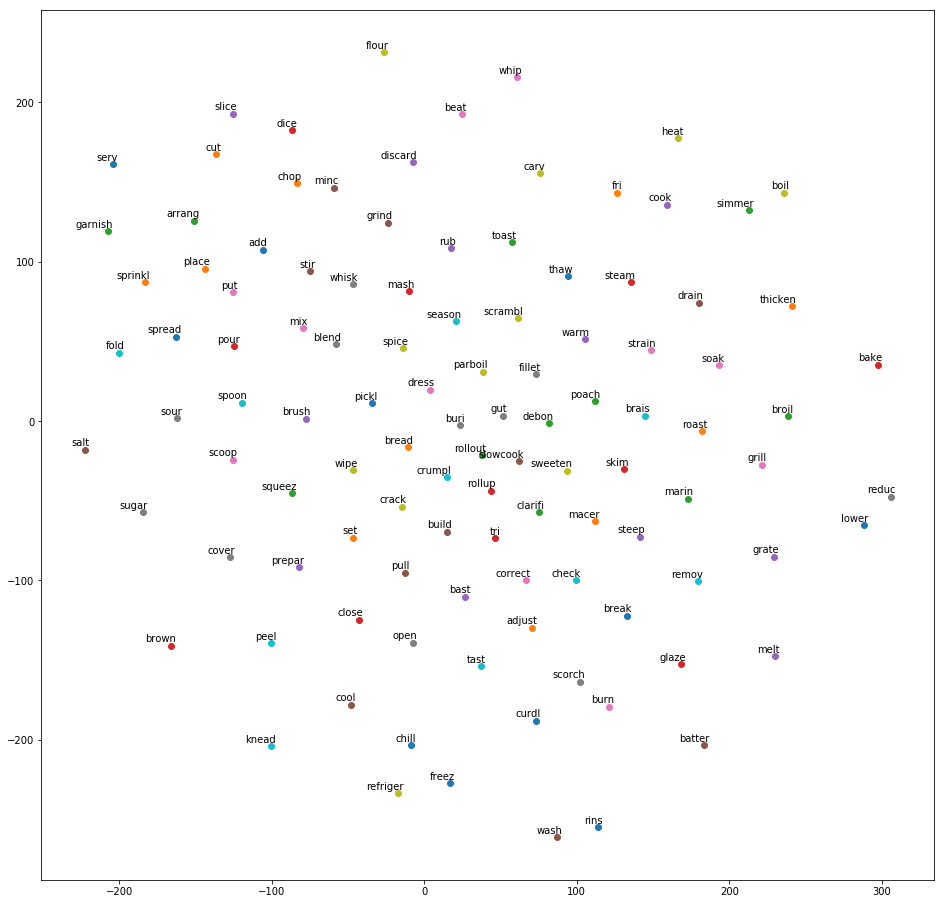

In [11]:
tsne_plot(stemmed_actions)

### 2D projection of combined Space

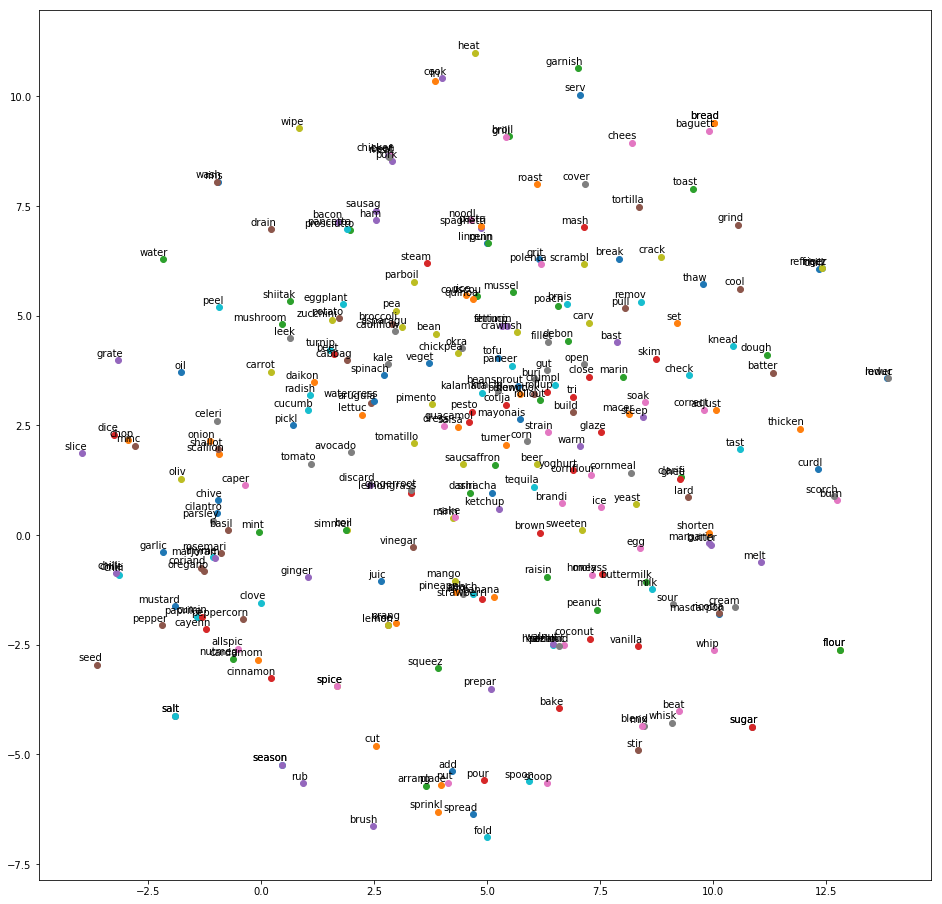

In [12]:
tsne_plot(stemmed_actions + stemmed_ingredients)

## cross-category-similarites
* now get the most likely ingredients for every action:

In [13]:
def find_most_similar_to_given_elementwise(unstemmed_targets, stemmed_comparison_list, n = 10):
    data = []
    for target in unstemmed_targets:
        comps = stemmed_comparison_list[:]
        bests = []
        for i in range(n):
            best = wv.most_similar_to_given(porter.stem(target), comps)
            comps.remove(best)
            bests.append(best)
        data.append([target] + bests)
    return pd.DataFrame(data, columns=["Target"] + ["#" + str(i+1) for i in range(n)])

### Cooking Action to Ingredient

In [14]:
HTML(find_most_similar_to_given_elementwise(model_actions, stemmed_ingredients).to_html())

### Ingredient to Cooking Action

In [15]:
HTML(find_most_similar_to_given_elementwise(model_ingredients, stemmed_actions).to_html())

----
## Inter-Category-Similarities
* checking self similarities:

### Cooking Action

In [16]:
HTML(find_most_similar_to_given_elementwise(model_actions, stemmed_actions).to_html())

### Ingredient

In [17]:
HTML(find_most_similar_to_given_elementwise(model_ingredients, stemmed_ingredients).to_html())